In [1]:
import numpy as np
import skimage.io as skio
from glob import glob
from matplotlib import pyplot as plt

In [65]:
from tqdm import tqdm


In [35]:
from skimage.transform import resize


In [17]:
from collections import defaultdict

In [2]:
full_paths_pics = glob('CU_dogs/training_133/*/*.jpg')

In [4]:
len(full_paths_pics)

4776

In [5]:
full_paths_pics[0]

'CU_dogs/training_133/104.miniature_schnauzer/miniature_schnauzer_010.jpg'

In [12]:
def get_half_path(s):
    s = s.split('/')
    s = s[2] + '/' + s[3]
    s = s[:-4]
    return s


In [13]:
half_paths = [get_half_path(s) for s in full_paths_pics]

In [18]:
titles_grouped_by_breed = defaultdict(list)

In [19]:
for s in full_paths_pics:
    s = s.split('/')
    titles_grouped_by_breed[s[2]].append(s[3][:-4])

In [29]:
import pandas as pd

In [22]:
import os

In [32]:
def grow_box(box, x_factor, y_factor):
    assert x_factor >= 1 and y_factor >= 1
    
    # make it a square
    
    w, h = box[2], box[3]
    
    target_size = max(int(w * (x_factor)), int(h * (y_factor)))
    
    overall_increase_x = target_size - w
    overall_increase_y = target_size - h
    return [box[0] - overall_increase_y//2, box[1] - overall_increase_x//2, box[2] + overall_increase_x, box[3] + overall_increase_y]
IMG_SIZE = 480

In [68]:
breeds = list(titles_grouped_by_breed.keys())

In [69]:
breeds[129], breeds[130]

('098.leonberger', '111.norwich_terrier')

In [70]:
remaining_breeds = breeds[129:]

In [71]:
remaining_breeds

['098.leonberger',
 '111.norwich_terrier',
 '092.keeshond',
 '013.australian_terrier']

In [73]:
for breed in ['111.norwich_terrier',
 '092.keeshond',
 '013.australian_terrier']:
    
    breed_dir = f"cropped_dogs/{breed}/"
    os.makedirs(breed_dir)
    
    img_dir = f"CU_dogs/training_133/{breed}/"
    pt_dir = f"CU_dogs/training_parts_15pts/{breed}/"
    
    titles = titles_grouped_by_breed[breed]
    
    
    img_array = np.zeros((len(titles), IMG_SIZE, IMG_SIZE, 3))
    
    pts_array = np.zeros((len(titles), 15, 2))
    
    titles_array = np.empty((len(titles)), dtype=str)
    
    for idx, title in enumerate(titles):
        
        img = skio.imread(img_dir + title + '.jpg')
        
        pts = pd.read_csv(pt_dir + title + ".txt", sep = ' ', header = None)
        points = np.array(pts)
        
        x_start = min(points[:,0])
        y_start = min(points[:,1])
        
        box = [min(points[:,1]), min(points[:,0]), max(points[:,0]) - min(points[:,0]), max(points[:,1]) - min(points[:,1])]
        
        
        big_box = np.array(grow_box(box, 1.7, 1.7)).astype(int)
        

        
        
        w, h = big_box[2], big_box[3]
        start_x, start_y = big_box[1], big_box[0]

        
        
        # adjust points to be relative of box
        points_adjusted = points - np.array([big_box[1], big_box[0]])
        points_relative = (points_adjusted.astype(float))/np.array([w, h])

        # pad top and left
        top_pad = max(-start_y, 0)
        left_pad = max(-start_x, 0)
        img_padded = np.pad(img, ((top_pad, 0), (left_pad, 0), (0,0)))
        start_x_adjusted = max(start_x, 0)
        start_y_adjusted = max(start_y, 0)

        # pad the bottom and right
        img_padded = np.pad(img_padded, ((0, max(0, h + start_y_adjusted - img_padded.shape[0])),
                                         (0 , max(0, w + start_x_adjusted - img_padded.shape[1])), (0,0)))

        # crop with the box
        img_cropped = img_padded[start_y_adjusted:start_y_adjusted + h, start_x_adjusted:start_x_adjusted+w, :]
        img_cropped = resize(img_cropped, (IMG_SIZE,IMG_SIZE), anti_aliasing=True)
        
        
        img_array[idx] = img_cropped
        pts_array[idx] = points_relative
        titles_array[idx] = title
    
    
    np.save(breed_dir + 'images.npy', img_array)
    np.save(breed_dir + 'points.npy', pts_array)
    np.save(breed_dir + 'titles.npy', titles_array)
    
        
        

        
        

In [44]:
test_out_2[0]

array([[192.702194,  99.833856],
       [297.326019, 117.467085],
       [188.39185 , 189.959248],
       [155.625   , 107.416563],
       [206.867925,  28.801887],
       [270.54717 ,  28.801887],
       [342.08805 ,  35.877358],
       [418.345912, 169.525157],
       [178.125   ,  94.948125],
       [208.125   , 106.198125],
       [281.875   , 119.323125],
       [315.625   , 119.323125],
       [178.125   , 187.448125],
       [204.375   , 188.698125],
       [193.335383, 222.134944]])

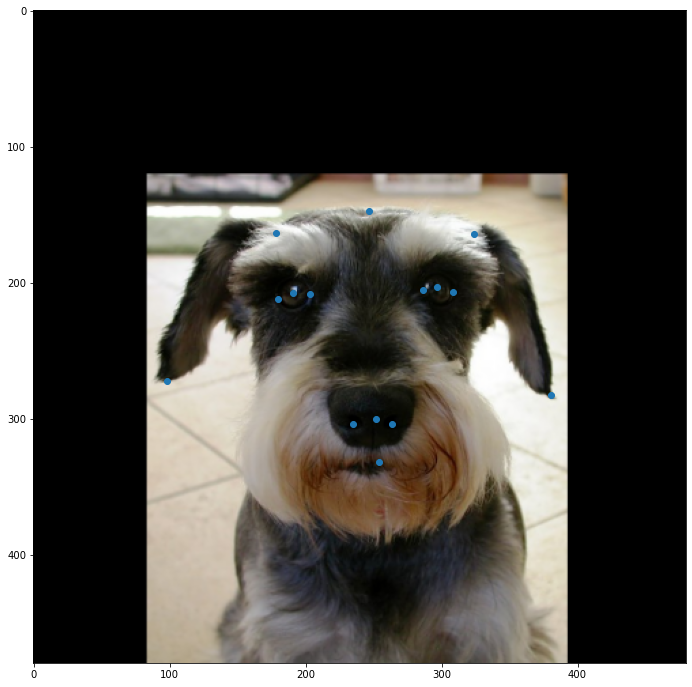

In [63]:
%matplotlib inline
plt.figure(figsize = (16,12))
plt.imshow(test_out[29])
plt.scatter(*zip(*(test_out_2[29] * np.array([IMG_SIZE, IMG_SIZE]))))
